# Author: Kiril Klein {-}

In [10]:
import sys
sys.path.append('../')

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import toolbox as tb
from toolbox import fits, vis
from toolbox import as_toolbox as ast
from toolbox.vis import Color_palette as Color_p
import urllib
from scipy import stats
from toolbox.ExternalFunctions import NLLH
#from mayavi import mlab
import nestle
#import corner
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import dtale

In [3]:
import importlib
_=importlib.reload(vis)

# Problem 2 {.unnumbered}

In [13]:
Data = pd.read_csv(
    "https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2017/data/data_exam_prob2.txt",
    sep=r"\s*", header = 0, engine='python')
loggamma = Data.iloc[:,0]
pht = Data.iloc[:,2]
spht = Data.iloc[:,3]
Data.head(3)

D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\pandas\io\parsers.py:2545: FutureWarning:

split() requires a non-empty pattern match.

D:\Programme\Anaconda\envs\tfCPU\lib\site-packages\pandas\io\parsers.py:2548: FutureWarning:

split() requires a non-empty pattern match.



,log(gamma),sig(log(gamma)),pHT,sig(pHT)
0,1.05,0.0,0.052,0.006
1,1.10,0.0,0.047,0.009
2,1.15,0.0,0.059,0.010


We choose $\alpha=0.05$ as a threshold, i.e. if the p-value is smaller, the hypothesis is rejected.

In [14]:
indices = np.arange(26,34)
def const_func(x,a): return np.ones_like(x)*a
P = []
for i, ind in enumerate(indices):
    x, y, sy = loggamma[:ind], pht[:ind], spht[:ind]
    fig, ax,fdict = fits.chi2_fit_func(x, y, sy, const_func, np.array([0.05]),
                                            kwargs = {'figsize':(12,10), 'show_plot':False})
    P.append(fdict['pval'])
    print(f"pvalue = {fdict['pval']:3.4f}", f" loggamma max = {loggamma[ind-1]:3.3f} ")

pvalue = 0.3815  loggamma max = 2.300 
pvalue = 0.3633  loggamma max = 2.350 
pvalue = 0.2484  loggamma max = 2.400 
pvalue = 0.2446  loggamma max = 2.450 
pvalue = 0.0679  loggamma max = 2.500 
pvalue = 0.0142  loggamma max = 2.550 
pvalue = 0.0121  loggamma max = 2.600 
pvalue = 0.0001  loggamma max = 2.650 


The hypothesis of a constant function holds for a $\log(gamma)\leq2.5$

We try to fit a sigmoid function with additional parameters.

In [15]:
#find good starting parameters
def f_sigmoid(x,a,b,c,d): return a/(1+np.exp(-(x-b)/c)) +d
xaxis = np.linspace(-10,10,100)
sigmoid = f_sigmoid(xaxis, .2,  2.8,.3,0.06)
fig, ax = vis.nice_plot(loggamma, pht, spht, errorbar=True, show_plot=False)
fig, ax= vis.nice_plot(xaxis, sigmoid, figure = fig, axis = ax)
#fig

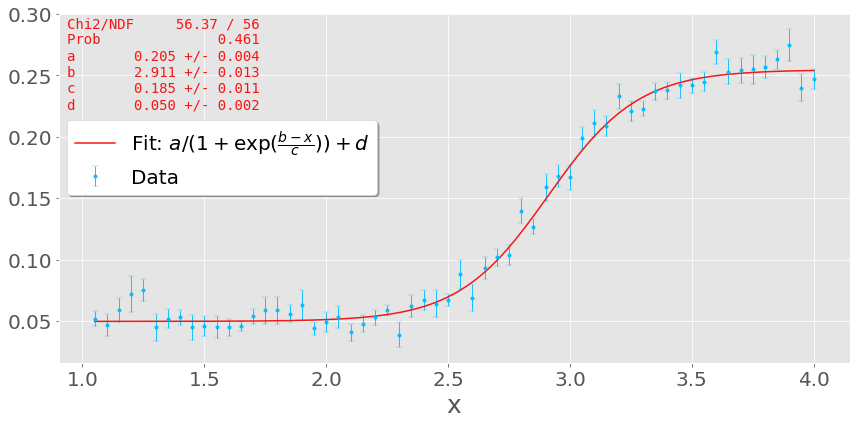

In [9]:
fig, ax, fdict = fits.chi2_fit_func(
    loggamma, pht, spht, f_sigmoid, [.2,  2.8,.3,0.06],
    fit_label="Fit: "+r"$a/(1+\exp{(\frac{b-x}{c})})+d$",
    kwargs = {'figsize':(12,6), 'show_plot':True, 
              'legend_loc':(0.01,.48), 'color_scheme':2})

# Problem 3 {-} 

In [4]:
def f_llikelihood(T):
    t1, t2, t3 = T
    sig = np.sqrt(0.04)
    mu = 0.68
    lh = 3*(np.cos(t1)*np.cos(t2)+1/(sig*np.pi*2)*np.exp(-(t3-mu)**2/(2*sig**2))*np.cos(t1/2)+3)
    pos_mask = lh>0
    llh = np.zeros_like(lh)
    llh[pos_mask] = np.log(lh[pos_mask])
    llh[~pos_mask] = -np.inf
    return llh
def prior_transform(x):
    return np.array([7*np.pi * x[0] , 7*np.pi * x[1], 3*x[2]])

In [174]:
#Lets explor it in 3d

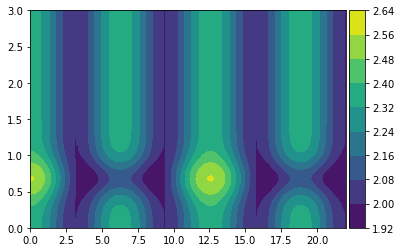

In [5]:
#just a test
t3 = np.linspace(0, 3)
t1 = np.linspace(0,7*np.pi,100)
t2 = 1#np.linspace(0,7*np.pi,100)
t11, t33 = np.meshgrid(t1,t3)
T = [t11,t2,t33]
fig, ax= plt.subplots()
im = ax.contourf(t11,t33, f_llikelihood(T))
divider = make_axes_locatable(ax)
cax0 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax0)

In [6]:
# Run nested sampling.
result = nestle.sample(
    f_llikelihood, prior_transform, 3, method = 'single', npoints = 6000)
logz = result.logz     # log evidence
logzerr = result.logzerr  # numerical (sampling) error on logz
samples = result.samples  # array of sample parameters
weights = result.weights  # array of weights associated with each sample
logl = result.logl
print(result.summary())

niter: 7843
ncall: 22070
nsamples: 13843
logz:  2.193 +/-  0.002
h:  0.016


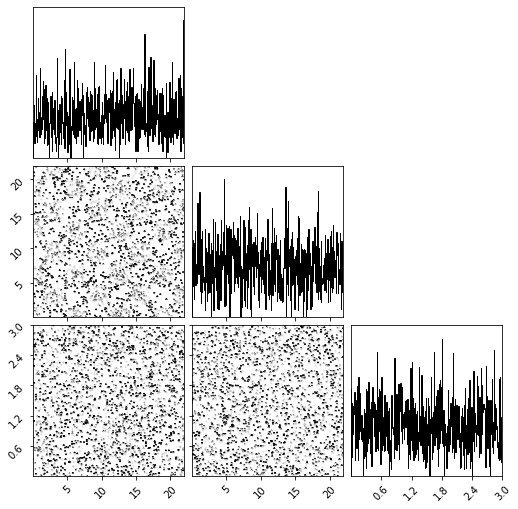

In [12]:
#fig = corner.corner(result.samples, weights=result.weights, bins=500,
#                    range=[(0., 7*np.pi), (0., 7*np.pi), (0., 3.)])
#fig.set_size_inches(8., 8.)

In [7]:
#maximum likelihood points
Tmax = samples[np.argmax(logl)]

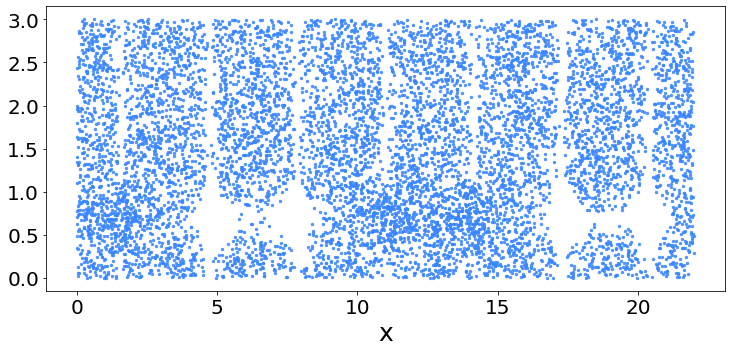

In [8]:
burn_in = 5000
fig, ax = vis.nice_plot(
    samples[burn_in:,0], samples[burn_in:,2], scatter = True, show_plot = False,
    alpha = .9, scr_markersize = 8, color = (10,4))
fig

In [8]:
%config Completer.use_jedi = False

In [9]:
#scan t2 t1 fix t3
t3opt = Tmax[2]
t1 = np.linspace(0,7*np.pi,100)
t2 = np.copy(t1)
t11, t22 = np.meshgrid(t1,t2)
T = [t11,t22,t3opt]
fig, ax= plt.subplots()
im = ax.contourf(t11,t22, f_llikelihood(T))
divider = make_axes_locatable(ax)
cax0 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax0)

NameError: name 'Tmax' is not defined

In [178]:
"""t1min, t2min, t3min = 0, 0, 0
t1max, t2max, t3max = 7*np.pi, 7*np.pi, 3
t1, t2, t3 = np.mgrid[t1min:t1max:.1, t2min:t2max:.1, t3min:t3max:.1]
pos = np.stack((t1, t2, t3), axis = 3)
density = f_likelihood(t1,t2,t3)
figure = mlab.figure('DensityPlot')
grid = mlab.pipeline.scalar_field(t1, t2, t3, density)
mlab.pipeline.volume(grid, vmin=density.min(), vmax=density.max())
#mlab.volume_slice(density, plane_orientation='y_axes', slice_index=10)
mlab.axes()
mlab.show()"""

"t1min, t2min, t3min = 0, 0, 0\nt1max, t2max, t3max = 7*np.pi, 7*np.pi, 3\nt1, t2, t3 = np.mgrid[t1min:t1max:.1, t2min:t2max:.1, t3min:t3max:.1]\npos = np.stack((t1, t2, t3), axis = 3)\ndensity = f_likelihood(t1,t2,t3)\nfigure = mlab.figure('DensityPlot')\ngrid = mlab.pipeline.scalar_field(t1, t2, t3, density)\nmlab.pipeline.volume(grid, vmin=density.min(), vmax=density.max())\n#mlab.volume_slice(density, plane_orientation='y_axes', slice_index=10)\nmlab.axes()\nmlab.show()"

# Problem 4 {-} 

In [52]:
f = urllib.request.urlopen("https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2017/data/GlobalTemp_1.txt")
#data = pd.read_csv(f, sep=' ', skipfooter=0, skiprows=1, skipinitialspace=True)
#data.shape
data = np.loadtxt(f, skiprows = 1)
Temp_dk = data[6,:]